# Tutorial - Bayes Tennis Package

## Prepare environment

In [38]:
import os
import sys
sys.path.insert(0, "../src")
from bayestennis.io import import_notion_csv
from bayestennis import TennisUniverse
import matplotlib.pyplot as plt
import torch
import numpy as np
from datetime import datetime, timedelta

## Load data

The first step involves loading a `TennisDataFrame`. In this tutorial, the function `import_notion_csv` is used:

In [39]:
file_path = "data_example.csv"
tdf = import_notion_csv(file_path)

tdf

,id_match,file_name,file_path,id_match_within_file,is_valid,error_msg,match_type,tournament,scoring_system,date,...,teamA_player1_name,id_teamA_player2,teamA_player2_name,id_teamB_player1,teamB_player1_name,id_teamB_player2,teamB_player2_name,score_AvsB_str,normalized_score_AvsB,winner_team
0,0,data_example.csv,data_example.csv,0,True,,single,AICS 2023,MrDodo,2023-06-01,...,Donatello Luciani,-1,None,1,Pellegrino Giovine,-1,None,6-4 6-1,"[6, 4, 6, 1, 0, 0]",Team A
1,1,data_example.csv,data_example.csv,1,True,,double,AICS 2023,MrDodo,2023-06-01,...,Lorenzo Bellomo,3,Matteo Pardi,4,Marcello Cibin,5,Pierluigi Pacomio,6-1 6-1,"[6, 1, 6, 1, 0, 0]",Team A
2,2,data_example.csv,data_example.csv,2,True,,single,AICS 2023,MrDodo,2023-06-01,...,Pardi Marco,-1,None,7,Lucio Conte,-1,None,6-1 7-6,"[6, 1, 7, 6, 0, 0]",Team A
3,3,data_example.csv,data_example.csv,3,True,,single,AICS 2023,MrDodo,2023-06-01,...,Calogero Battelli,-1,None,9,Uberto Oliboni,-1,None,6-0 6-4,"[6, 0, 6, 4, 0, 0]",Team A
4,4,data_example.csv,data_example.csv,4,True,,double,AICS 2023,MrDodo,2023-06-01,...,Giuseppe Cavalcanti,11,Gioacchino Flaiano,12,Federico Gatto,13,Delfino Mozart,6-1 6-0,"[6, 1, 6, 0, 0, 0]",Team A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,379,data_example.csv,data_example.csv,379,True,,single,Mr. Dodo 22 - Fase Eliminatoria,MrDodo,2022-02-01,...,Fulvio Zoppetti,-1,None,129,Gianni Guarana,-1,None,5-7 2-6,"[5, 7, 2, 6, 0, 0]",Team B
380,380,data_example.csv,data_example.csv,380,True,,double,Mr. Dodo 22 - Fase Eliminatoria,MrDodo,2022-02-01,...,Atenulf Solimena,34,Adriano Spinelli,51,Giacinto Orengo,55,Manuel Cannizzaro,5-7 3-6,"[5, 7, 3, 6, 0, 0]",Team B
381,381,data_example.csv,data_example.csv,381,True,,single,Mr. Dodo 22 - Fase Eliminatoria,MrDodo,2022-02-01,...,Gabriele Fantoni,-1,None,115,Ennio Rizzoli,-1,None,3-6 7-6 7-10,"[3, 6, 7, 6, 7, 10]",Team B
382,382,data_example.csv,data_example.csv,382,True,,single,Mr. Dodo 22 - Fase Eliminatoria,MrDodo,2022-02-01,...,Manuel Cannizzaro,-1,None,116,Pasqual Dovara,-1,None,6-3 7-6,"[6, 3, 7, 6, 0, 0]",Team A


 ### Inspect `is valid` field

 Check the `error_msg` field to find out why a match has been marked as invalid:

In [40]:
tdf_non_valid = tdf[~tdf['is_valid']]
tdf_non_valid = tdf_non_valid[["id_match", "file_name", "id_match_within_file", "is_valid", "error_msg"]]
tdf_non_valid

,id_match,file_name,id_match_within_file,is_valid,error_msg
15,15,data_example.csv,15,False,Players B not admittable: nan
16,16,data_example.csv,16,False,Players B not admittable: nan
17,17,data_example.csv,17,False,Players B not admittable: nan
30,30,data_example.csv,30,False,Players B not admittable: nan
84,84,data_example.csv,84,False,Unable to understand score: 6-3 0-6 x-10
91,91,data_example.csv,91,False,"Players name not admittable: ['boh1', 'boh2']"
166,166,data_example.csv,166,False,Players name not admittable: ['boh1']
287,287,data_example.csv,287,False,Unable to understand score: Vinta polaccidi
378,378,data_example.csv,378,False,Unable to understand score: 2-5 5-7 x-10


### Set custom log-likelihood weights

By default, `import_notion_csv` computes log-likelihood weights based on the days between the match date and `datetime.now()`. You can also set custom weights; here, we use the distance to the most recent date in the dataframe:

In [41]:
# Compute elapsed days
last_date = tdf['date'].max()  # or datetime.now() ?
tdf['elapsed_days'] = (last_date - tdf['date']) / timedelta(days=1)

# Compute log likelihood weights
half_life_days = 8 * 30  # 8 months
tdf['log_likelihood_weight'] = 2 ** (-tdf['elapsed_days'] / half_life_days)

## Create Tennis Universe

The second step involves creating a `TennisUniverse` object from the `TennisDataFrame`:

In [42]:
tu = TennisUniverse(tdf)
tu

TennisUniverse(n_players=205, n_matches=375)

You can inspect the automatically generated `PlayersDataFrame`:

In [43]:
tu.playersDataFrame

,id_player,name,ability,rank,n_singles,n_doubles,n_matches,last_date,last_tournament
0,0,Donatello Luciani,NaN,NaN,9,4,13,2023-06-01,AICS 2023
1,1,Pellegrino Giovine,NaN,NaN,1,1,2,2023-06-01,AICS 2023
2,2,Lorenzo Bellomo,NaN,NaN,6,8,14,2023-06-01,AICS 2023
3,3,Matteo Pardi,NaN,NaN,6,9,15,2023-06-01,AICS 2023
4,4,Marcello Cibin,NaN,NaN,1,1,2,2023-06-01,AICS 2023
...,...,...,...,...,...,...,...,...,...
200,200,Nino Lombardo,NaN,NaN,1,0,1,2022-02-01,Mr. Dodo 22
201,201,Gilberto Bonatti,NaN,NaN,1,0,1,2022-02-01,Mr. Dodo 22
202,202,Cipriano Turchi,NaN,NaN,1,2,3,2022-02-01,Mr. Dodo 22
203,203,Tullio Gabbana,NaN,NaN,0,2,2,2022-02-01,Mr. Dodo 22


You can inspect the automatically generated `Loss` function:

In [44]:
tu.loss

Loss Function. Terms:
  MrDodo: LogLikelihoodTerm(scoring_system=MrDodo, n_matches=375)
  Regularization: L2_Regularization(coupling_const=0.15915494309189535)

## Optimization Routine

Use the `optimize()` method to run the optimization routine and find the maximum posterior estimate of player abilities:

In [45]:
optimization_info = tu.optimize()

(tic)
Optimization started:
  0 / 1000: Loss = 1426.971436
  100 / 1000: Loss = 1171.043457
  200 / 1000: Loss = 1171.012085
  300 / 1000: Loss = 1171.011841
  400 / 1000: Loss = 1171.011963
  500 / 1000: Loss = 1171.011963
  600 / 1000: Loss = 1171.011963
  700 / 1000: Loss = 1171.011963
  800 / 1000: Loss = 1171.011963
  900 / 1000: Loss = 1171.011963
  1000 / 1000: Loss = 1171.011963 (end)
(toc) 3.36 s


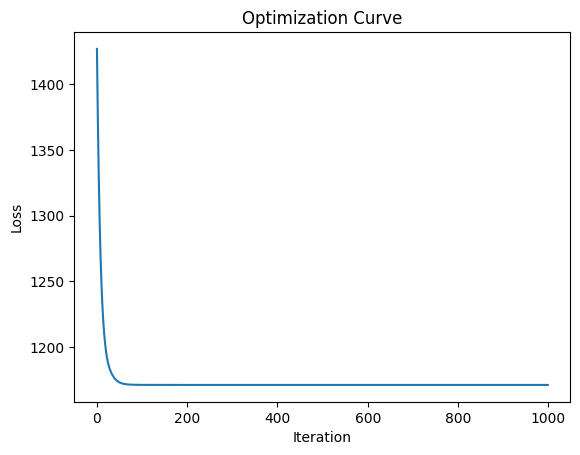

In [46]:
plt.figure()
plt.plot(optimization_info['idx_iteration'], optimization_info['loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Optimization Curve")
plt.show()

## Abilities and Ranking

Once the optimization routine ends, the `ability` and `rank` fields in the `PlayersDataFrame` are automatically updated:

In [47]:
pdf = tu.playersDataFrame.sort_values(by=['rank'])
pdf

,id_player,name,ability,rank,n_singles,n_doubles,n_matches,last_date,last_tournament
97,97,Cirillo Pisaroni,104.081139,1,8,1,9,2023-06-01,AICS 2023
10,10,Giuseppe Cavalcanti,103.866547,2,0,4,4,2023-06-01,AICS 2023
98,98,Dionigi Vecellio,103.685532,3,9,0,9,2023-06-01,AICS 2023
67,67,Carlo Peano,103.632866,4,8,0,8,2023-06-01,AICS 2023
56,56,Gianluigi Caccianemico,103.631927,5,4,0,4,2023-06-01,AICS 2023
...,...,...,...,...,...,...,...,...,...
4,4,Marcello Cibin,97.117493,201,1,1,2,2023-06-01,AICS 2023
75,75,Sandro Abba,96.915245,202,2,0,2,2023-06-01,AICS 2023
124,124,Gionata Gulotta,96.628624,203,2,0,2,2023-02-01,Mr. Dodo 23 - Fase Eliminatoria
58,58,Lazzaro Luna,96.170334,204,3,0,3,2023-06-01,AICS 2023


## Export

You can export the `PlayersDataFrame` like any other pandas dataframe:

In [48]:
file_name, file_ext = os.path.splitext(file_path)
out_file_path = file_name + "_ranking.xlsx"
pdf.to_excel(out_file_path, index=False)